# Modeling

2017-07-13 MJ Rose with scripts from J. Callingham

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
import numpy as np
import os, glob, subprocess, time, psutil, sys, shutil, fnmatch
import pandas as pd
import pymultinest,os, threading, subprocess,time, math
import scipy.optimize as opt
import scipy.stats as stats
import scipy.special as special # For access to the incomplete gamma function.
import emcee, corner, inspect
from collections import namedtuple
from collections import OrderedDict
import copy



if not os.path.exists("chains"): os.mkdir("chains") # This is important.
# This makes a directory called "chains". This is where the walker information
# is being stored by Multinest. All Pymultinest does is then read them in.

# Joe's SED plotting 
import seds_plot_func
from gpscssmodels import *

# my own
from reduction_funcs import *

# read in data
sedfile = 'sed_df.pkl'
sed_loc = os.getcwd()+"/"+sedfile
sed_df = pd.read_pickle(sed_loc)

# set save path
image_dir = "/Users/mmcintosh/Dropbox/ASTRON2017/C3030/model_plots/"
if not os.path.exists(image_dir):
	os.makedirs(image_dir)
    
    
# default source to model
interactive = False
source = 59

# prep the data

In [67]:

freq_arr = sed_df.loc[source]["freq"]*1000 # in MHz
flux_arr = sed_df.loc[source]["flux"]
flux_err_arr = sed_df.loc[source]["flux_err"]
name = sed_df.loc[source]["name"]
print(name)

x = freq_arr
y = flux_arr
yerr = flux_err_arr
freq_cont = np.linspace(np.min(freq_arr),np.max(freq_arr),1000)

pks1740-649


In [68]:
# custom function 
def get_argnames(func):
    return(func.__code__.co_varnames[:func.__code__.co_argcount][1:])


def help_unpack(theta):
    if isinstance(theta,np.ndarray):
        return(copy.copy(theta))
    else:
        # its probably a generator func from multinest
        temp = [theta[i] for i in np.arange(ndim)]
        return(temp)

def init_repeated_params(arg, param):
    ''' if you have something like Snorm, Snorm2, Snorm3
    then this function places them at 2x, 4x, 6x ... out 
    from the original Snorm '''
    temp = re.search('\d', arg)
    if temp is not None:
        occurance = int(temp.group())
        if occurance >= 2:
            param = param *2*(occurance -1)
    return(param)


def make_prior_dictionary(func, x,y):
    argnames = get_argnames(func)
    # set up prior information
    Prior = namedtuple('Prior', ['guess', 'min', 'max'])
    keys = []
    for arg in argnames:
        if "norm" in arg:
            param = Prior(init_repeated_params(arg, np.max(y)), 0.0, 1e+3)
        elif "alpha" in arg:
            param = Prior(0.7, 0.0, 10.0)
        elif "freq" in arg:
            param = Prior(init_repeated_params(arg, x[np.argmax(y)]), 0.0, 1e+5)
        elif "p" in arg:
            param = Prior(-0.3, -10.0, 10.0)
        elif "beta" in arg:
            param = Prior(3, -10.0, 1.0)
        elif "gamma" in arg:
            param = Prior(1, 0.0, 10.0)
        elif 'q' in arg:
            param = Prior(1, 0.0, 10.0)
        else:
            param = Prior(1, 0.0, 1e+5)
        keys.append(param)
    dictionary = OrderedDict(zip(argnames, keys))
    return(dictionary)

def check_if_in_prior(theta, prior_dict, set_to_nearest=False, set_to_random=False): 
    ''' if parameters are within the prior boundaries, returns them. Otherwise, it returns False.
    set_to_nearest replaces the out of bounds value with the nearest boundary'''
    params = help_unpack(theta)
    for i, (name, prior) in enumerate(prior_dict.items()): 
        if not (prior.min <= params[i] < prior.max):
            #if set_to_nearest: 
                # if not within prior bounds, set the param equal to the closest boundary
                #params[i] = min([prior.min, prior.max], key=lambda x:abs(x-params[i]))
            if set_to_random:
                # if not within prior bounds, set it to a random value in between max & min
                params[i] = np.random.uniform(prior.min,prior.max,1)
            else:
                return(False)
    return(params)

# for both emcee and multinest
def lnlike(theta, ndim, nparams):
    #(theta,x,y,yerr,func):
    params = help_unpack(theta)
    inv_sigma = 1.0/(yerr**2)
    loglike = -0.5*(np.nansum((y-func(x,*params))**2*inv_sigma - np.log(inv_sigma))) 
    
    # the model will return -0.0 if it gets a divide by zero error, 
    # which happens if the parameters are too big
    if loglike == -0.0:
        loglike = -np.inf
    return(loglike)

def emcee_lnprior(theta, prior_dict): 
    params = check_if_in_prior(theta, prior_dict)
    if not isinstance(params, list):
        return(-np.inf)
    else:
        # flat prior
        return(0.00)
   
def multinest_lnprior(cube, ndim, n_params):
    '''This transforms a unit cube into the dimensions of your prior
    space to search. Make sure you do this right!'''
    for i in np.arange(ndim):
        cube[i] = cube[i] * emcee_fit[i]*sig
    
        
def emcee_lnprob(theta, ndim, n_params, prior_dict):
    lp = emcee_lnprior(theta, prior_dict)
    if not np.isfinite(lp):
        return -np.inf
    prob = lp + lnlike(theta, ndim, n_params)
#     if np.random.rand() < 0.001:
#         print(prob, theta)
    return(prob)

def redchisq(ydata,ymod,sd,parafreq_arrm):
    chisq=np.sum(((ydata-ymod)/sd)**2)
    freq_arr=ydata.size-parafreq_arrm-1
    return [chisq, chisq/freq_arr]

def populate_walkers(ndim, scale, nwalkers, prior_dict, guess=None, set_to_random=False):
    # initializes random positions, running it through the prior
    # do I need to pass a random seed? 
    # if set_to_random = false, then it adds noise to 0.0 for out of bound guesses
    pos = []
    counter = 0 
    while len(pos) < nwalkers:
        counter +=1
        # generate random scatter
        test_theta = [(prior.max-prior.min)*scale*np.random.uniform(-1,1) for name, prior in prior_dict.items()]
        #print(test_theta)
        # add it to an initial guess if you have one
        if guess is not None:
            new_guess = check_if_in_prior(guess, prior_dict, set_to_random=set_to_random)
            if isinstance(new_guess, np.ndarray):
                #print('guess',guess[-1])
                test_theta += new_guess
                #print('theta',test_theta[-1])
        # if this is within the prior, keep it
        test_theta = check_if_in_prior(test_theta, prior_dict)
        if isinstance(test_theta, np.ndarray):
            pos.append(test_theta)
        if counter > 1e+5:
            print('check your scale, populate_walkers has reached 1e+5 iterations')
            return(None)
    return(pos)


def make_plot_labels(func):
    input_list = func.__code__.co_varnames[1:]
    labels = []
    for i in input_list:
        if 'freq' in i:
            i=i.replace('freq',"\\nu") 
        temp = i.split('_')
        if len(temp) > 1:
            labels.append(temp[0]+'_{{{0}}}'.format(temp[1]))
        else:
            if i in ['alpha','beta']:
                i = "\\"+i
            match = re.match("([a-z]+)([0-9]+)", i, re.I)
            if match:
                items = match.groups()
                labels.append('\\'+items[0]+'_{{{0}}}'.format(items[1]))
            else:
                labels.append(i)
    labels = ["$"+i+"$" for i in labels]
    return(labels)


In [69]:
# model_list = ([singhomobremss,singhomobremsscurve,singhomobremssbreak,singhomobremssbreakexp,
#                singinhomobremss,singinhomobremsscurve,singinhomobremssbreak, singinhomobremssbreakexp,
#                doubhomobremss,doubhomobremsscurve, doubhomobremssbreakexp,
#                singSSA,singSSAbreakexp,
#                doubSSA,doubSSAbreakexp,
#                tripSSA,quadSSA,
#                powlaw,powlawbreak,powlawbreak_nophys,powlawexp,
#                internalbremss,
#                curve,curvepowlaw,duffcurve,logduffcurve])


# Model

fitting models: ['singSSA']
fitting with singSSA
first guess: [4.3260000000000005, 3, 4850.0]
Optimization terminated successfully.
         Current function value: 2.730614
         Iterations: 65
         Function evaluations: 121


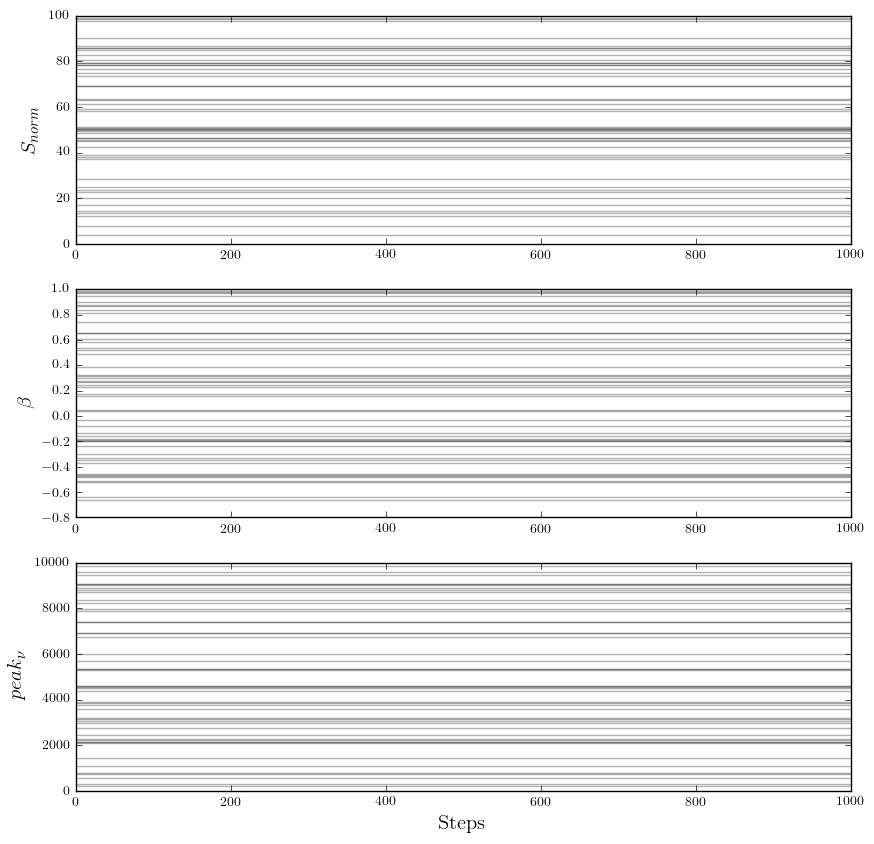

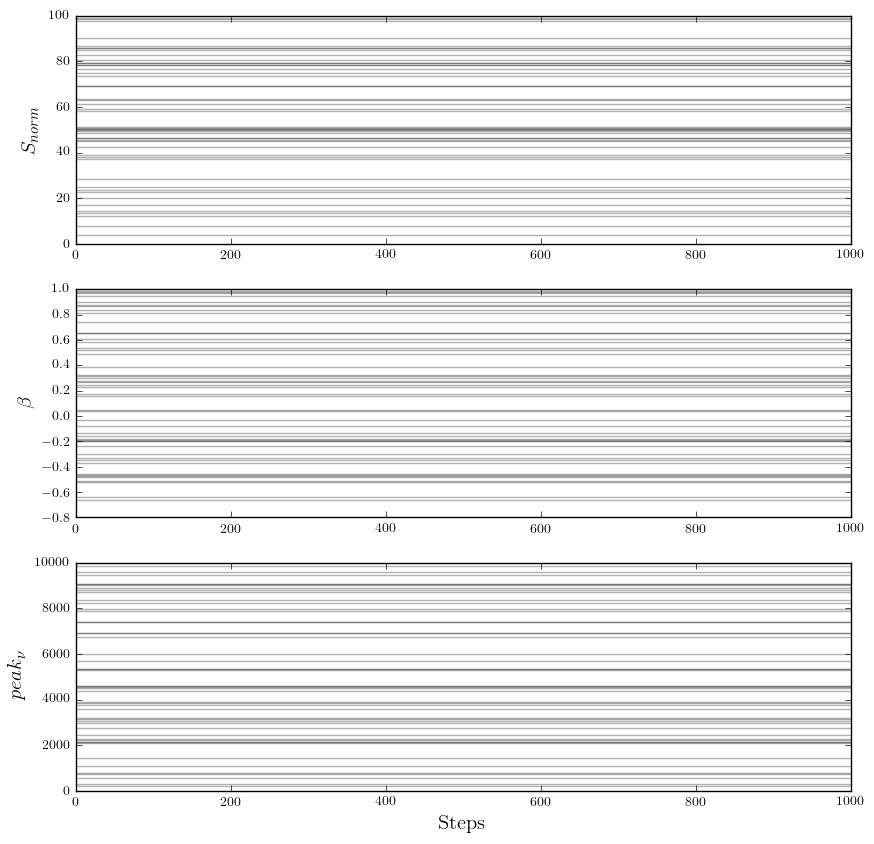

In [71]:
interactive = False
model_list = [singSSA]#[singSSA, doubSSA,singinhomobremss,singinhomobremssbreak,singinhomobremssbreakexp,doubhomobremss, doubSSAbreakexp]
model_names = [func.__name__ for func in model_list]
print('fitting models: {0}'.format(model_names))
models = pd.DataFrame(index = model_names, columns=['leastsquares', 'emcee', 'multinest'])
for func in model_list:
    print('fitting with {0}'.format(func.__name__))
    ndim = (func.__code__.co_argcount - 1)
    n_params = ndim #oddly, this needs to be specified
    prior_dict = make_prior_dictionary(func, x,y)
    # your guess
    guess = [value.guess for key, value in prior_dict.items()]
    print('first guess: {0}'.format(guess))
    # set least squares fit to be the initial parameter guess for fmin
    popt, pcov = opt.curve_fit(func, freq_arr, flux_arr, p0 = guess, sigma = flux_err_arr)

    redchisq_list = redchisq(flux_arr,func(freq_arr,*popt),flux_err_arr,len(inspect.getargspec(func)[0])-1)

    leastsquares = pd.DataFrame(data=[[0]], columns=['initial_guess'], index=[0],dtype=object)
    leastsquares['popt'] = [popt]
    leastsquares['pcov'] = [pcov]
    leastsquares['redchisq'] = [redchisq_list]
    leastsquares['initial_guess'] = [guess]
    models.set_value(func.__name__,'leastsquares', leastsquares)



    # flip our likelihood function so that when we minimize nll, we are max'ing our likelihood?
    nll = lambda *args: -lnlike(*args)

    # minimize function with downhill simplex algorithm
    # returns array of paramaters that minimizes the input function, value of function at that min, number of iterations, number of function calls
    # warningflag 1 (max func evals reached) or 2 (max iter reached), solution at each iteration
    result = opt.fmin(nll, popt, args=(ndim,n_params), full_output='true')

    
    ndim, nwalkers, nsteps = len(inspect.getargspec(func)[0])-1, 50, 1000 
    rand_seed = 45
    np.random.seed(rand_seed) 
    # Initialising the walkers in a Gaussian ball around maximum likelihood result
#     pos = [result[0]+ 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    #pos = [result[0]+ np.abs(10*np.random.randn(ndim)) for i in range(nwalkers)]
    scale = 1e-1 # noise scale, should be less than 1 
    pos = populate_walkers(ndim, scale, nwalkers, prior_dict, guess=result[0], set_to_random=True)
    # initializing walkers randomly
    #pos = np.random.rand(nwalkers, ndim)

#     print('*lnprior1*', list(map(lambda p: emcee_lnprior(p), pos)))
#     print('*lnlike*', list(map(lambda p: lnlike(p, ndim, n_params), pos)))
#     print('*lnprob*', list(map(lambda p: emcee_lnprob(p, min_arr,max_arr), pos)))
    

    # for the prior
    sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_lnprob, args=(ndim, n_params, prior_dict))
    sampler.run_mcmc(pos, nsteps) # This is the workhorse step.

    fig = plt.figure(2,figsize=(10, 10))
    fig.clf()
    for j in range(ndim):
        ax = fig.add_subplot(ndim,1,j+1)
        ax.plot(np.array([sampler.chain[:,i,j] for i in range(nsteps)]),"k", alpha = 0.3)
        ax.set_ylabel((make_plot_labels(func))[j], fontsize = 15)
    plt.xlabel('Steps', fontsize = 15)
    display(fig)

    #############
    break       #
    #############
    if interactive:
        burnin = int(input('burnin?'))
    else:
        burnin = 200
    fig.clf()


    # To me it looks like the burn in period is well and truly over by n steps. So I will exclude those. 
    print( 'The burnin applied was {0}. Make sure the walkers have converged after that many steps.'.format(burnin))
    samples = sampler.chain[:,burnin:,:].reshape((-1,ndim))
    # Plotting the histograms of the fit.
    trifig = corner.corner(samples, labels = make_plot_labels(func))
    #trifig.savefig(image_dir+'/{0}_{1}'.format(name,func.__name__))
    plt.close()

    # Finally to get the final uncertainties you do
    uncertainties_mcmc = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples,[16,50,84], axis = 0)))) # Uncertainites based on the 16th, 50th and 84th percentile.
    emcee_fit = np.asarray([u[0] for u in uncertainties_mcmc])

    flux_arr_store = np.zeros((200,1000))
    lower_flux_arr, upper_flux_arr = np.zeros(1000), np.zeros(1000)

    j=0
    for sample in samples[np.random.randint(len(samples), size=200)]:
        for i in range(1000):
            flux_arr_store[j,i] = func(freq_cont[i], *sample)
            lower_flux_arr[i], upper_flux_arr[i] = np.percentile(flux_arr_store[:,i],[16,84], axis = 0)
        j = j+1

    mc = pd.DataFrame(data=[[0]], columns=['nwalkers'], index=[0], dtype=object)
    mc['nwalkers'] = nwalkers
    mc['nsteps'] = nsteps
    mc['burnin'] = burnin
    mc['rand_seed'] = rand_seed
    mc['uncertainties'] = [uncertainties_mcmc]
    mc['lowerfluxarr'] = [lower_flux_arr]
    mc['upperfluxarr'] = [upper_flux_arr]
    mc['fit'] = [emcee_fit]

    models.set_value(func.__name__,'emcee', mc)



    # multinest
    # number of dimensions our problem has
    ndim = (func.__code__.co_argcount - 1)
    n_params = ndim #oddly, this needs to be specified
    print('emcee fit: {0}'.format(emcee_fit))

    # sigma away from emcee's guess
    sig = 3
    pymultinest.run(lnlike,multinest_lnprior,n_params, resume = False, verbose = True,sampling_efficiency = 0.3)

    # lets analyse the results
    a = pymultinest.Analyzer(n_params = n_params) #retrieves the data that has been written to hard drive
    s = a.get_stats()
    values = s['marginals'] # gets the marginalized posterior probability distributions 
    mn_fit = [values[i]['median'] for i in np.arange(len(values))]
    multinest = pd.DataFrame(data=[[0]], columns=['marginals'], index=[0], dtype=object)
    multinest['fit'] = [mn_fit]
    for key in s:
        if isinstance(s[key], list):
            pass
        else:
            multinest[key] = s[key]

    marginals = pd.DataFrame.from_dict(s['marginals'], dtype=None)
    modes = pd.DataFrame.from_dict(s['modes'], dtype=None)
    multinest.set_value(0,'marginals', marginals)
    multinest.set_value(0,'modes', modes)

    models.set_value(func.__name__,'multinest', multinest)

    print('summary for {0}'.format(func.__name__))
    print(" "*20+'{0}'.format(func.__code__.co_varnames[:func.__code__.co_argcount][1:]))
    print('leastsquares fit:{0}'.format(popt))
    print('emcee fit: {0}'.format(emcee_fit))
    print('multinest fit:{0}'.format(mn_fit))
    print('diff bw emcee and multinest:')
    print(np.subtract(emcee_fit,mn_fit))



## Debugging

OrderedDict([('S_norm1', Prior(guess=4.3260000000000005, min=0.0, max=1000.0)), ('S_norm2', Prior(guess=8.652000000000001, min=0.0, max=1000.0)), ('beta1', Prior(guess=3, min=-10.0, max=1.0)), ('beta2', Prior(guess=3, min=-10.0, max=1.0)), ('peak_freq1', Prior(guess=4850.0, min=0.0, max=100000.0)), ('peak_freq2', Prior(guess=9700.0, min=0.0, max=100000.0))]) [  3.23174667e-02  -2.42418650e+01  -3.09085170e-01   9.28588939e+00
   6.28022512e-01   7.97561481e+03]
S_norm1


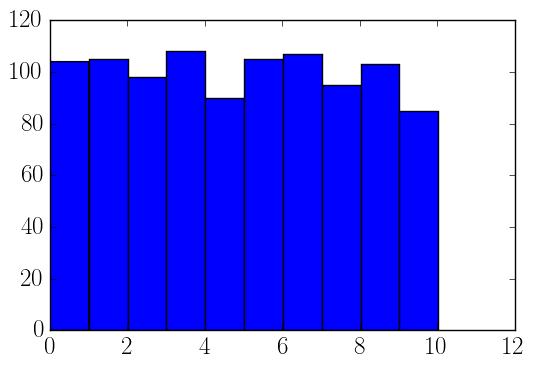

S_norm2


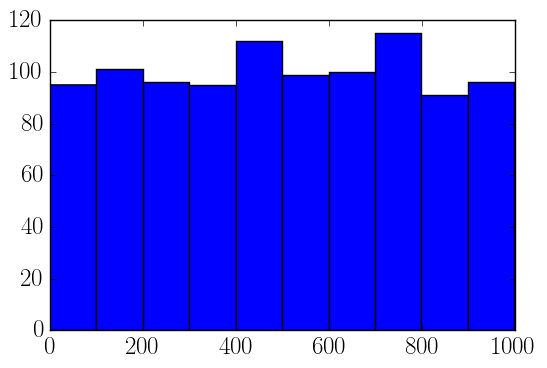

beta1


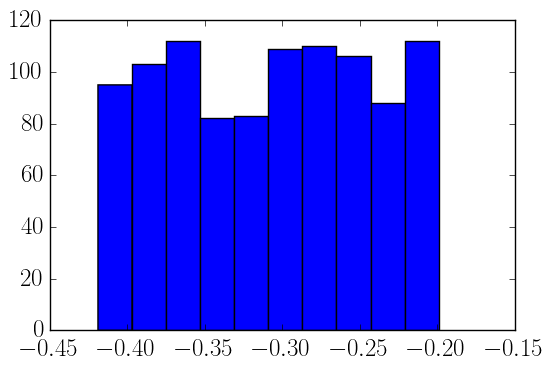

beta2


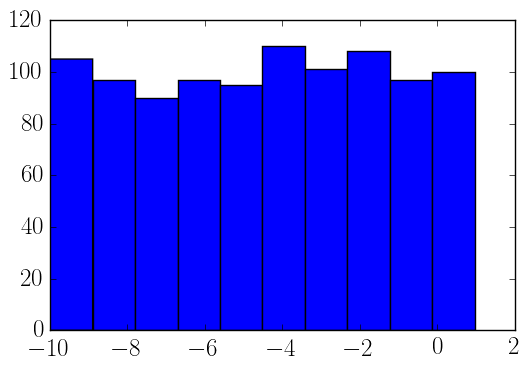

peak_freq1


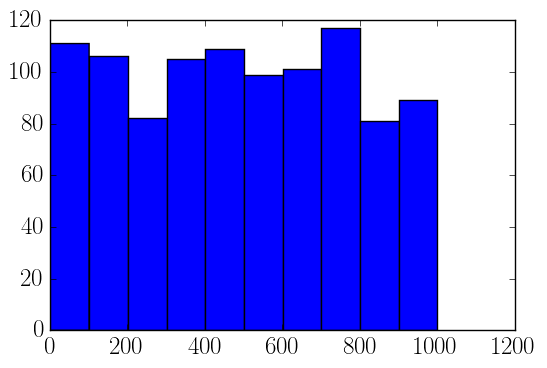

peak_freq2


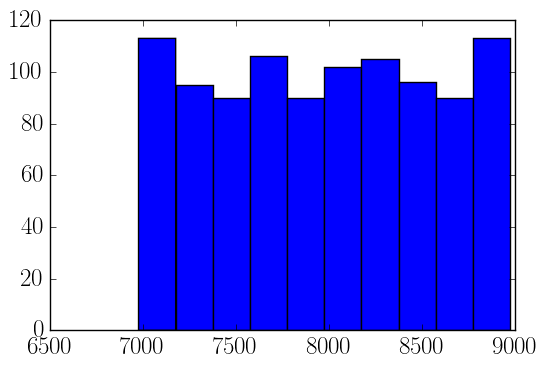

In [64]:
print(prior_dict,result[0])
argnames = get_argnames(func)
pos = populate_walkers(ndim, 1e-2, 1000, prior_dict, guess=result[0], set_to_random=True)
for i, arg in enumerate(argnames):
    print(arg)
    plt.hist([p[i] for p in pos])
    plt.show()

In [54]:
prior_dict

OrderedDict([('S_norm1', Prior(guess=4.3260000000000005, min=0.0, max=1000.0)),
             ('S_norm2', Prior(guess=8.652000000000001, min=0.0, max=1000.0)),
             ('beta1', Prior(guess=3, min=-10.0, max=1.0)),
             ('beta2', Prior(guess=3, min=-10.0, max=1.0)),
             ('peak_freq1', Prior(guess=4850.0, min=0.0, max=100000.0)),
             ('peak_freq2', Prior(guess=9700.0, min=0.0, max=100000.0))])

In [60]:
check_if_in_prior(result[0], prior_dict, set_to_random=True)

array([  3.23174667e-02,   9.16056206e+02,  -3.09085170e-01,
        -3.97762361e+00,   6.28022512e-01,   7.97561481e+03])

In [348]:
scale = 1e-4
test_theta = []
for i, (name, prior) in enumerate(prior_dict.items()): 
    test_theta.append((prior.max-prior.min)*scale*np.random.uniform(-1,1,1))
print(type(test_theta), test_theta)

<class 'list'> [-7.913644871737844, 0.0001958764293552995, 3.8725271809835604]


In [357]:
test_theta = [(prior.max-prior.min)*scale*np.random.uniform(-1,1) for name, prior in prior_dict.items()]
test_theta

[3.5980095635335063, -0.00021216695098895034, 2.9764449770729073]

In [107]:
# print out evidence
for idx in models.index:
    mn_evidence = models.loc[idx].multinest['nested sampling global log-evidence'].values[0]
    mn_evidence_err = models.loc[idx].multinest['nested sampling global log-evidence error'].values[0]
    print('multinest evidence for {0}: {1:.2f} +/- {2:.2f}'.format(idx,mn_evidence,mn_evidence_err))

multinest evidence for singSSA: -11.26 +/- 0.13
multinest evidence for doubSSA: 21.42 +/- 0.17
multinest evidence for singinhomobremss: 5.55 +/- 0.15
multinest evidence for singinhomobremssbreak: 26.34 +/- 0.15
multinest evidence for singinhomobremssbreakexp: 23.74 +/- 0.15
multinest evidence for doubhomobremss: 30.71 +/- 0.15
multinest evidence for doubSSAbreakexp: 14.67 +/- 0.21


In [ ]:
# SED plotting
# residuals don't work yet

print('least squares')
# least squares fit plot
fit_list = [models.loc[model.__name__].leastsquares.popt[0] for model in model_list]

plot = seds_plot_func.sed(model_list,fit_list,freq_arr,
           flux_arr,flux_err_arr, name, 
           freq_labels = True, savefig = False, resid=True)

plot.savefig(image_dir+'/{0}_{1}.png'.format(name,'leastsquares'), bbox_inches='tight')
plt.close()


print('emcee')
# emcee fit plot
fit_list = [models.loc[model.__name__].emcee.fit[0] for model in model_list]

plot = seds_plot_func.sed(model_list,fit_list,freq_arr,
               flux_arr,flux_err_arr, name, 
               freq_labels = True, savefig = False, resid=True)

plot.savefig(image_dir+'/{0}_{1}.png'.format(name,'emcee'), bbox_inches='tight')
plt.close()


print('multinest')
# multinest fit plotting
fit_list = [models.loc[model.__name__].multinest.fit[0] for model in model_list]

plot = seds_plot_func.sed(model_list,fit_list,freq_arr,
                   flux_arr,flux_err_arr, name, 
                   freq_labels = True, savefig = False, resid=True)
plot.savefig(image_dir+'/{0}_{1}.png'.format(name,'multinest'), bbox_inches='tight')
plt.close()


In [ ]:
# latex stuff
for index in np.arange(len(16)):
    
if parameter not in model:
    toprint = '$\cdots$'
else:
    toprint = '{1:.2f}'.format(value)
    #find_param_uncertainty(value)
    toprint += '$\pm$ {0:.2f} &'.format(value)

In [ ]:
# work on latex table

r'\begin{sidewaystable}
	\renewcommand{\arraystretch}{2}
	\scriptsize
	\centering
	\caption{\label{longtable} Best fit parameters and their associated uncertainties for the different absorption models. }
		\begin{tabular}{lcccccccccccc}
		\hline
		\hline
Models & $a_{1}$ (Jy) &  $a_{2}$ (Jy) & $\alpha_{1}$ & $\alpha_{2}$ & $\beta_{1}$ & $\beta_{2}$  & $\nu_{\mathrm{p},1}$ (GHz)  & $\nu_{\mathrm{p},2}$ (GHz)  & $p$  & $\nu_{\mathrm{br}}$ (GHz) & $\chi^{2}_{\mathrm{red}}$ & $\ln(Z)$ \\
				\hline		
	{0}  & {1:.2f} $\pm$ {2:.2f} &  {3} &  {4} $\pm$ {5}    & {6}  &  {7} & {8} & {9} $\pm$ {10}   &  {11} & {12} & {13}  & {14} & {15} $\pm${16} \\
	 Double Homogeneous FFA & 3.6 $\pm$ 0.2 &  5.8 $\pm$ 0.2 & $-1.27^{+0.05}_{-0.04}$  &  $-1.28$ $\pm$ 0.03 & $\cdots$	& $\cdots$  & 0.293 $\pm$ 0.007  & 0.93 $\pm$ 0.05  & $\cdots$ & $\cdots$ & 5.52 & $-422.4$ $\pm$ 0.2 \\
	 Inhomogeneous FFA  & 12.0 $\pm$  0.3 &   $\cdots$ &  $-1.221$ $\pm$ 0.008 & $\cdots$  &$\cdots$ &$\cdots$ & 0.75 $\pm$ 0.02 & $\cdots$ & 0.24 $\pm$ 0.04 & $\cdots$ & 5.72& $-419.0$ $\pm$ 0.6\\
	 Internal FFA & 8.8 $\pm$ 0.1 &  $\cdots$ & $-1.240$ $\pm$ 0.008  &  $\cdots$ & $\cdots$& $\cdots$ & 0.90 $\pm$ 0.02 & $\cdots$ & $\cdots$ & $\cdots$ & 7.13 & $-567.4$ $\pm$ 0.2\\
	   Single SSA & 13.4 $\pm$ 0.2  & $\cdots$ & $\cdots$ &$\cdots$ & 3.27 $\pm$ 0.01 	& $\cdots$ & 0.575 $\pm$ 0.008  & $\cdots$   & $\cdots$ & $\cdots$ & 13.83& $-609.5$ $\pm$ 0.1 \\
	Double SSA & 12.2 $\pm$ 0.3 & 2.5 $\pm$ 0.2 & $\cdots$ & $\cdots$ & 3.48 $\pm$ 0.06 &  3.56$^{+0.08}_{-0.07}$ & 0.459 $\pm$ 0.009  &  1.56 $\pm$ 0.7 & $\cdots$& $\cdots$ &5.36 & $-408.5$ $\pm$ 0.3\\
	 Single SSA + exp. break & 12.4 $\pm$  0.2 	& $\cdots$ &$\cdots$ &  $\cdots$ & 2.61 $\pm$ 0.03 & $\cdots$  & 0.75 $\pm$ 0.02  & $\cdots$ & 13.7 $\pm$ 0.7 & $\cdots$ & 2.39 & $-336.6$ $\pm$ 0.2\\
	 Double SSA + exp. break & 8.3$^{+0.6}_{-0.7}$ & 6.1$^{+0.7}_{-0.6}$  & $\cdots$  &  $\cdots$ & 3.3$^{+0.3}_{-0.2}$ &  2.55$^{+0.06}_{-0.08}$ & 0.34$^{+0.07}_{-0.08}$   &  0.73$^{+0.04}_{-0.05}$ & $\cdots$ & 12 $\pm$ 2 & 1.09 & $-305.8$ $\pm$ 0.3 \\
	 Inhomogeneous FFA + exp. break & 12.9 $\pm$  0.3	& $\cdots$ & $-0.93$ $\pm$ 0.02  & $\cdots$ &$\cdots$ & $\cdots$& 0.55 $\pm$ 0.02  & $\cdots$ & 0.37$^{+0.07}_{-0.06}$ & 19 $\pm$ 1 & 0.80 & $-304.1$ $\pm$ 0.1\\
		\hline
		\end{tabular}
\end{sidewaystable}'

In [ ]:
# save data frame
model_path = sed_loc.split('sed_df')
model_path = model_path[0] + name + model_path[-1]
models.to_pickle(model_path)